# Global Diferential Privacy Assessement: Univariate case

In this notebook, we will explore the univariate case of the Global Differential Privacy using a different application. After running this notebook, you will be able to:
- Understand the concept and applying Gaussian based Global Differential Privacy for univariate case.

We also run a monte carl simulation to validate the GDP implementation.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil
import wget
from rich import print

## Global Differential Privacy

Global Differential Privacy (DP) is a mathematical framework that provides strong, quantifiable privacy guarantees when analyzing and sharing data. Its core idea is to ensure that the inclusion or exclusion of a single individual’s data does not significantly affect the output of an analysis, thereby limiting what can be inferred about any one person. This limits the ability of an attacker to infer whether someone participated in the dataset, even if they possess additional background information. To achieve this, DP algorithms inject calibrated random noise into outputs.

## User Output

A data user has an analysis pipeline that s run on the data. The output of such pipeline is then made differentially private.

Here, the pipeline simply consists in computing the mean.


In [6]:
def user_output(clean_data):

    pipeline_output = np.mean(clean_data)
    return pipeline_output

## GDP algorithm

The procedure take the user pipeline and data and applies a leave one out (loo) resampling to the data to obtain the influence function, i.e. the output of the user pipeline for each loo resample are compared to the user output. The maximum of that gives the lower bound of the noise to be applied (i.e. it provides the information on the observation which has the largest influence).  



## Noise Extraction - Laplace Vs. Gaussian Distribution

Here, we compare noise sampling strategies from Normal and Laplace distributions for use in our DP setting. The goal is to assess how different distributions behave when bounded by a known sensitivity which is estimated via LOO sampling.

loo_output: [160.89935412852654, 163.7270528765457, 164.91347366051968, 163.25614873033484, 
163.32418016923282, 163.69562790419138, 162.51919591566164, 163.93895974924985, 
163.6664212628161, 162.72075568750284], 
pipeline_output: 163.26611700845814

sensitivity: 2.366762879931599

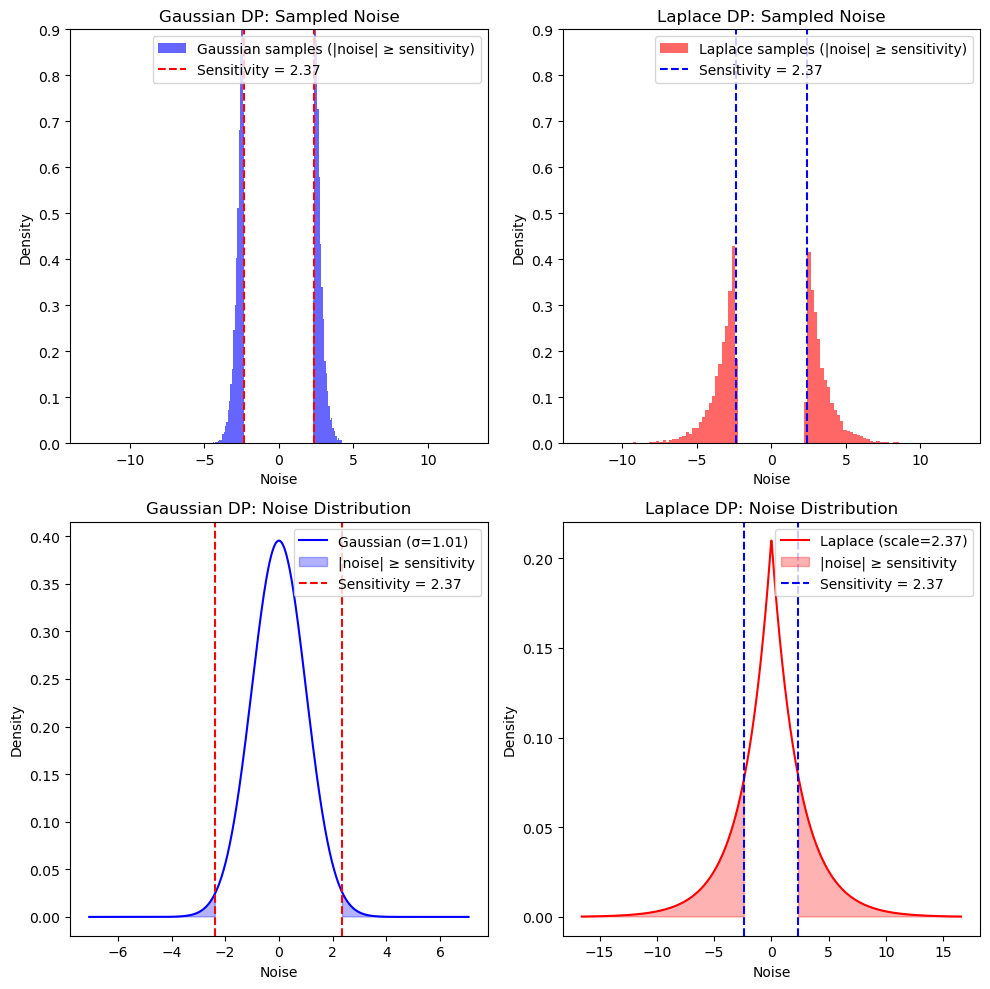

In [13]:
from scipy.stats import norm, laplace
clean_data = np.random.normal(loc=170, scale=10, size=10)
loo_data = np.array([np.delete(clean_data, i) for i in range(len(clean_data))])
pipeline_output = user_output(loo_data)
loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
print(f"loo_output: {list(loo_output)}, \npipeline_output: {pipeline_output}")
sensitivity = np.max(np.abs(loo_output - pipeline_output))
print(f"\nsensitivity: {sensitivity}")
n = len(clean_data)

loo_scale = np.std(loo_output)  
noise_gaussian = []
for _ in range(10000):
    while True:
        noise = np.random.normal(loc=0, scale=loo_scale)
        if np.abs(noise) >= sensitivity:
            noise_gaussian.append(noise)
            break

scale_laplace = sensitivity 
noise_laplace = []
for _ in range(10000):
    while True:
        noise = np.random.laplace(loc=0.0, scale=loo_scale)
        if np.abs(noise) >= sensitivity:
            noise_laplace.append(noise)
            break


# VIZ

plt.figure(figsize=(10, 10))  

plt.subplot(2, 2, 1) 
plt.hist(noise_gaussian, bins=100, density=True, alpha=0.6, color='blue', 
         label='Gaussian samples (|noise| ≥ sensitivity)')
plt.axvline(x=sensitivity, color='red', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='red', linestyle='--')
plt.title('Gaussian DP: Sampled Noise')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()
plt.xlim(-14, 14)
plt.ylim(0, 0.9)

plt.subplot(2, 2, 2)  
plt.hist(noise_laplace, bins=100, density=True, alpha=0.6, color='red', 
         label='Laplace samples (|noise| ≥ sensitivity)')
plt.axvline(x=sensitivity, color='blue', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='blue', linestyle='--')
plt.title('Laplace DP: Sampled Noise')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()
plt.xlim(-14, 14)
plt.ylim(0, 0.9)

plt.subplot(2, 2, 3)  
x_g = np.linspace(-7*loo_scale, 7*loo_scale, 1000)
plt.plot(x_g, norm.pdf(x_g, 0, loo_scale), 'b-', label=f'Gaussian (σ={loo_scale:.2f})')
plt.fill_between(x_g, norm.pdf(x_g, 0, loo_scale), 
                 where=(np.abs(x_g) >= sensitivity), color='blue', alpha=0.3,
                 label='|noise| ≥ sensitivity')
plt.axvline(x=sensitivity, color='red', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='red', linestyle='--')
plt.title('Gaussian DP: Noise Distribution')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()

plt.subplot(2, 2, 4)  
x_l = np.linspace(-7*scale_laplace, 7*scale_laplace, 1000)
plt.plot(x_l, laplace.pdf(x_l, 0, scale_laplace), 'r-', label=f'Laplace (scale={scale_laplace:.2f})')
plt.fill_between(x_l, laplace.pdf(x_l, 0, scale_laplace), 
                 where=(np.abs(x_l) >= sensitivity), color='red', alpha=0.3,
                 label='|noise| ≥ sensitivity')
plt.axvline(x=sensitivity, color='blue', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='blue', linestyle='--')
plt.title('Laplace DP: Noise Distribution')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

## Different setup for noise 

**Why Use 2 * std for Normal Distribution?**

In a Gaussian distribution, roughly 95% of the data falls within +/- 2 standard deviations. When we're sampling noise, that must exceed a minimum threshold (the sensitivity), a standard deviation that is too small will result in excessive rejection sampling, simply saying, most noise samples are too small and get discarded.

By using 2 * std:

- We increase the spread of the distribution.
- This reduces the rejection rate, allowing more efficient sampling of noise that meets the sensitivity requirement.
- It reflects a practical compromise between privacy guarantees and computational efficiency for tail sampling.

loo_output: [165.38160094513395, 165.23503757883933, 166.1075369715687, 165.69346209936685, 
167.02549250834483, 166.98340026511644, 164.9230503853467, 164.7812387935304, 
166.7567886669075, 166.47875013605255], 
pipeline_output: 165.9366358350207

sensitivity: 1.1553970414902892

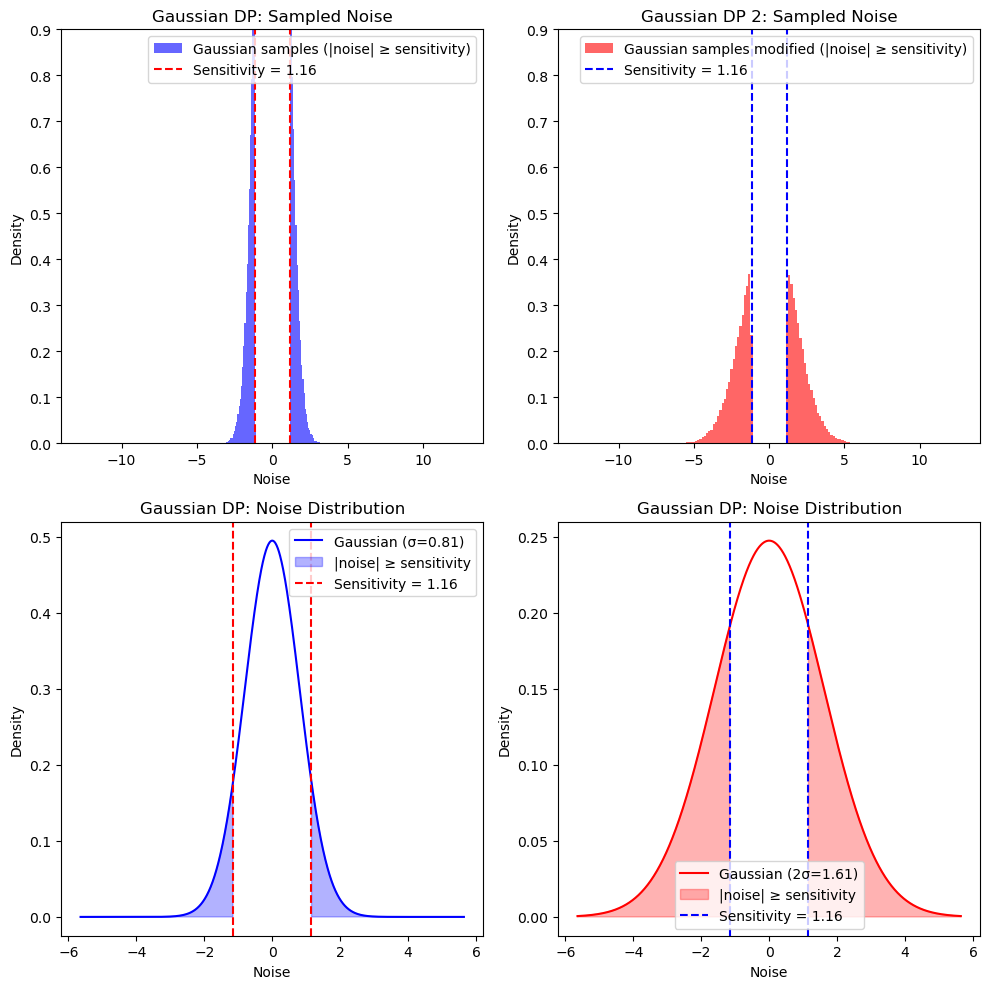

In [14]:
clean_data = np.random.normal(loc=170, scale=10, size=10)
loo_data = np.array([np.delete(clean_data, i) for i in range(len(clean_data))])
pipeline_output = user_output(loo_data)
loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
print(f"loo_output: {list(loo_output)}, \npipeline_output: {pipeline_output}")
sensitivity = np.max(np.abs(loo_output - pipeline_output))
print(f"\nsensitivity: {sensitivity}")

n = len(clean_data)

loo_scale = np.std(loo_output)  
#scale = max(loo_scale, sensitivity / np.sqrt(2 * np.log(1.1)))  
noise_gaussian = []
for _ in range(100000):
    while True:
        noise = np.random.normal(loc=0, scale=loo_scale)
        if np.abs(noise) >= sensitivity:
            noise_gaussian.append(noise)
            break

noise_gaussian_2 = []
for _ in range(100000):
    while True:
        noise = np.random.normal(loc=0, scale=2 * loo_scale)
        if np.abs(noise) >= sensitivity:
            noise_gaussian_2.append(noise)
            break



# VIZ
plt.figure(figsize=(10, 10))  

plt.subplot(2, 2, 1) 
plt.hist(noise_gaussian, bins=100, density=True, alpha=0.6, color='blue', 
         label='Gaussian samples (|noise| ≥ sensitivity)')
plt.axvline(x=sensitivity, color='red', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='red', linestyle='--')
plt.title('Gaussian DP: Sampled Noise')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()
plt.xlim(-14, 14)
plt.ylim(0, 0.9)

plt.subplot(2, 2, 2)  
plt.hist(noise_gaussian_2, bins=100, density=True, alpha=0.6, color='red', 
         label='Gaussian samples modified (|noise| ≥ sensitivity)')
plt.axvline(x=sensitivity, color='blue', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='blue', linestyle='--')
plt.title('Gaussian DP 2: Sampled Noise')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()
plt.xlim(-14, 14)
plt.ylim(0, 0.9)

plt.subplot(2, 2, 3)  
x_g = np.linspace(-7*loo_scale, 7*loo_scale, 1000)
plt.plot(x_g, norm.pdf(x_g, 0, loo_scale), 'b-', label=f'Gaussian (σ={loo_scale:.2f})')
plt.fill_between(x_g, norm.pdf(x_g, 0, loo_scale), 
                 where=(np.abs(x_g) >= sensitivity), color='blue', alpha=0.3,
                 label='|noise| ≥ sensitivity')
plt.axvline(x=sensitivity, color='red', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='red', linestyle='--')
plt.title('Gaussian DP: Noise Distribution')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()

plt.subplot(2, 2, 4)  
x_l = np.linspace(-7*loo_scale, 7*loo_scale, 1000)
plt.plot(x_l, norm.pdf(x_l, 0, 2 * loo_scale), 'r-', label=f'Gaussian (2σ={(2*loo_scale):.2f})')
plt.fill_between(x_g, norm.pdf(x_l, 0, 2*loo_scale), 
                 where=(np.abs(x_l) >= sensitivity), color='red', alpha=0.3,
                 label='|noise| ≥ sensitivity')
plt.axvline(x=sensitivity, color='blue', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='blue', linestyle='--')
plt.title('Gaussian DP: Noise Distribution')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# Main Pipeline

In [16]:
def dp(clean_data,pipeline_output):


    loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
    loo_scale = np.std(loo_output)
    sensitivity = np.max(np.abs(loo_output - pipeline_output))
    while True:
        noise = np.random.normal(loc=0.0, scale=2 * loo_scale)
        if abs(noise) >= sensitivity:
            break

    noisy_output = pipeline_output + noise
    return noisy_output, sensitivity

def iqr_bounds(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return iqr, lower_bound, upper_bound

def outlier_(value, lower, upper):
    return value < lower or value > upper
    

In [17]:
def sim(n_replicates, subsample_sizes, OL=True):    
    id_dr = {size: np.zeros(size) for size in subsample_sizes} # stands for index detection rates
    counts = {size: 0 for size in subsample_sizes}
    reconstructed = {size: [] for size in subsample_sizes}
    true_means_ = {size: [] for size in subsample_sizes}
    sensitivities_ = {size: [] for size in subsample_sizes}
    error_ = {size: [] for size in subsample_sizes}
    
    for n in range(n_replicates):
        data = np.random.normal(loc=170, scale=10, size=200)
        for size in subsample_sizes:
            subsample = data[:size].copy()
            iqr_, lower_b, upper_b = iqr_bounds(subsample)
            
            if OL:
                outlier_val = lower_b - 100
                subsample[0] = outlier_val
            else: pass

            true_mean = np.mean(subsample)
            true_means_[size].append(true_mean)
            loo_data = np.array([np.delete(subsample, i) for i in range(len(subsample))])
            ######## PIPELINE ########
            noisy_outputs = []
            sens_outputs = []
            for loo_subset in loo_data:
                output = user_output(loo_subset)
                noisy_output, sensitivity_ = dp(loo_subset, output)
                noisy_outputs.append(noisy_output)
                sens_outputs.append(sensitivity_)
                
            ######## RECONSTRUCTION ########
            coeff_mat = np.ones((size, size)) - np.eye(size)
            recons = np.linalg.solve(coeff_mat, (size - 1) * np.array(noisy_outputs))
            iqr_, lower_b, upper_b = iqr_bounds(recons)
            recons_error = np.mean(abs(recons - subsample))
            error_[size].append(recons_error)
            sensitivities_[size].append(sens_outputs)
            reconstructed[size].append(recons)
            
            if outlier_(recons[0], lower_b, upper_b):
                counts[size] += 1
                
            for idx in range(size):
                if outlier_(recons[idx], lower_b, upper_b):
                    id_dr[size][idx] += 1
    return id_dr, counts, reconstructed, sensitivities_, error_

n_replicates = 1000
subsample_sizes = [20, 40, 60, 80, 100]

#id_dr_OL, counts_OL, reconstructed_OL, sensitivities_OL, error_OL = sim(n_replicates, subsample_sizes, OL=True)
id_dr, counts, reconstructed, sensitivities_, error_ = sim(n_replicates, subsample_sizes, OL=False)

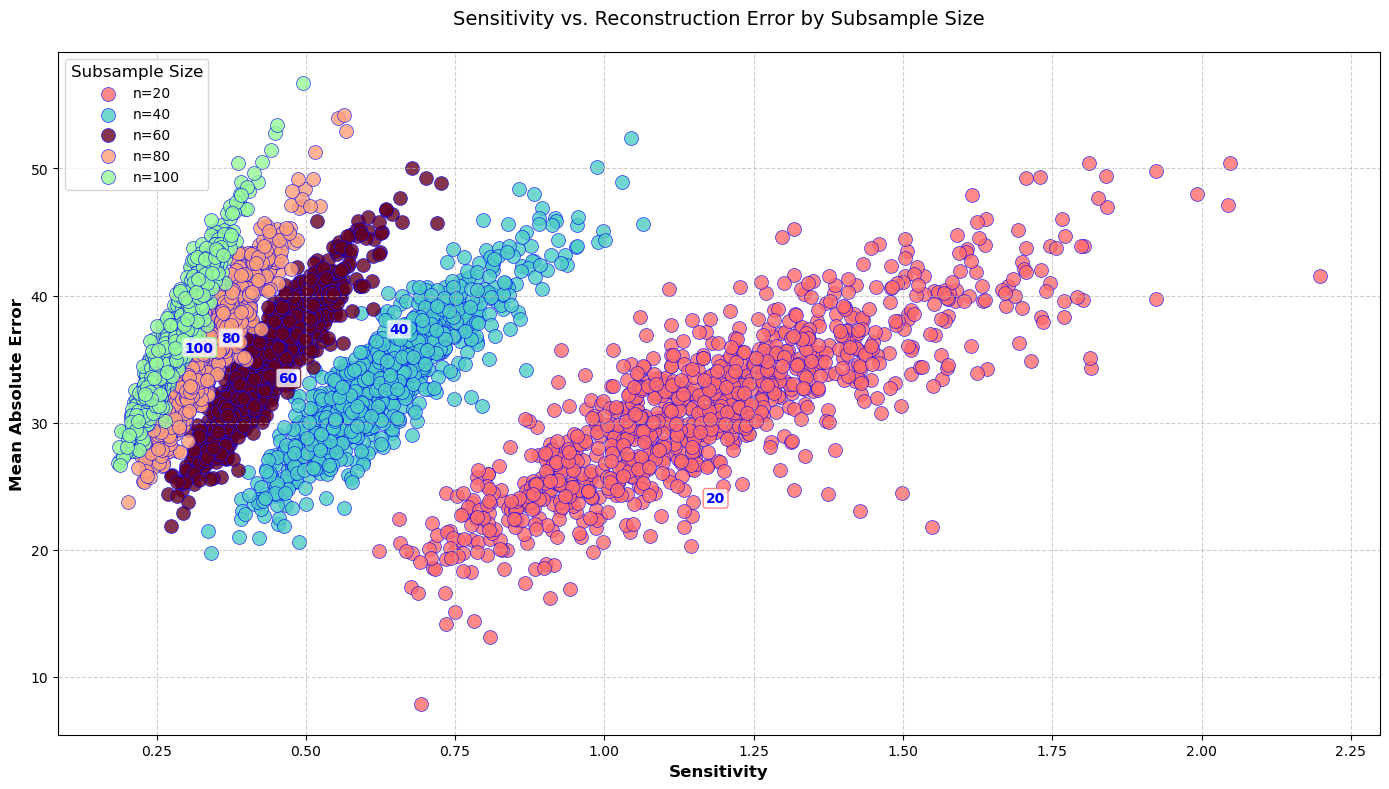

In [19]:
color_map = {
    20: '#FF6B6B',  
    40: '#4ECDC4', 
    60: '#650021', 
    80: '#FFA07A',  
    100: '#98FB98' 
}

plt.figure(figsize=(14, 8))

for size in subsample_sizes:
    mean_sensitivity = np.mean(np.array(sensitivities_[size]), axis=1)
    plt.scatter(mean_sensitivity, 
                np.array(error_[size]),
                color=color_map[size],
                s=100,  
                alpha=0.8,
                edgecolors='b',  
                linewidth=0.5,
                label=f'n={size}')

    median_idx = np.argsort(mean_sensitivity)[len(mean_sensitivity)//2]
    plt.annotate(f'{size}',
                 xy=(mean_sensitivity[median_idx], np.array(error_[size])[median_idx]),
                 xytext=(10, 10),  
                 textcoords='offset points',
                 fontsize=10,
                 fontweight='bold',
                 color="b", 
                 bbox=dict(boxstyle='round,pad=0.2', 
                          fc='white', 
                          ec=color_map[size],  
                          alpha=0.8))

plt.xlabel('Sensitivity', fontsize=12, fontweight='bold')
plt.ylabel('Mean Absolute Error', fontsize=12, fontweight='bold')
plt.title('Sensitivity vs. Reconstruction Error by Subsample Size', 
          fontsize=14, pad=20)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Subsample Size', title_fontsize=12)

plt.tight_layout()
plt.show()

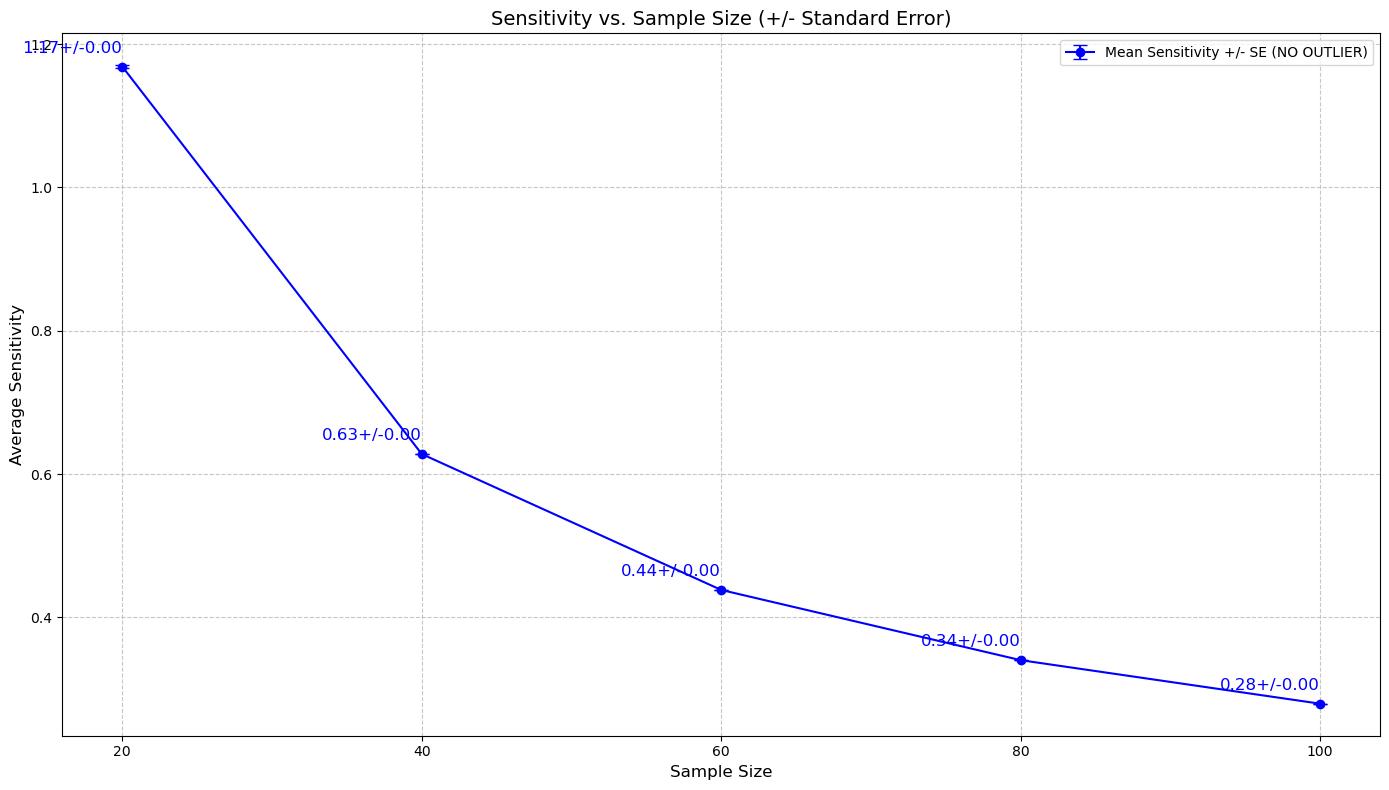

In [22]:
mean_sensitivities = list()
std_errors = list()

for size in subsample_sizes:
    all_sensitivities = np.array(sensitivities_[size]).flatten()
    mean_sens = np.mean(all_sensitivities)
    std_err = np.std(all_sensitivities) / np.sqrt(len(all_sensitivities))
    mean_sensitivities.append(mean_sens)
    std_errors.append(std_err)
    
plt.figure(figsize=(14, 8))

plt.errorbar(
    subsample_sizes, mean_sensitivities, yerr=std_errors,
    fmt='o-', capsize=5, color='blue',
    label='Mean Sensitivity +/- SE (NO OUTLIER)'
)


for size, sens, err in zip(subsample_sizes, mean_sensitivities, std_errors):
    plt.annotate(
        f"{sens:.2f}+/-{err:.2f}", 
        (size, sens),
        textcoords="offset points", 
        xytext=(0, 10),
        ha='right', 
        fontsize=12,
        color='blue'
    )


plt.xlabel('Sample Size', fontsize=12)
plt.ylabel('Average Sensitivity', fontsize=12)
plt.title('Sensitivity vs. Sample Size (+/- Standard Error)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(subsample_sizes)
plt.legend(fontsize=10, loc='upper right')

plt.tight_layout()
plt.show()

[10.9, 10.6, 10.4, 9.8, 10.299999999999999]

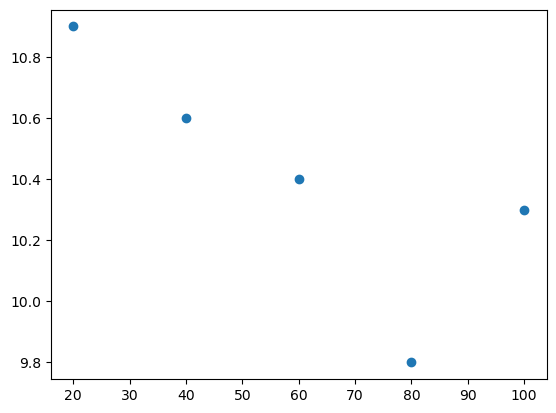

In [37]:
a = [(counts[size] / n_replicates) * 100 for size in subsample_sizes]
print(a)
b = subsample_sizes
plt.scatter(b,a)

In [45]:
prc = {size: (id_dr[size] / n_replicates) * 100 for size in subsample_sizes}
print(prc)

for n, flags in id_dr.items():
    percentages = (flags / n_replicates) * 100
    mean = np.mean(percentages)
    se = np.std(percentages, ddof=1) / np.sqrt(len(flags))
    print("se", se)

{
    20: array([10.9, 10.3, 11.4, 10.1, 10. , 10.9,  9.9,  9.6, 10.7, 11.3, 11.5,
       12. , 10.3, 10.4,  9.5, 11.1, 10.2, 12. , 10.3, 12. ]),
    40: array([10.6,  9.3, 11. ,  9.9, 10.2, 11.1, 10.4, 10.6,  9.6, 10.8, 11.2,
       11. , 10. , 11.5,  9. ,  9.4, 10.2,  9.3, 11.1,  9.9, 10. , 10.2,
        9.5, 10.1, 10.5, 11.7,  9. ,  9.6,  8. , 10.3,  9.8, 10.2,  8. ,
       11.5, 10.8,  9.5,  9.5, 10.3, 10.3, 10.8]),
    60: array([10.4,  9.7, 11.8,  9.6,  8.2, 12. ,  7.8,  9.8,  8.3,  9.8,  9.8,
       11.8, 11.6, 11.3,  7.9,  9.6, 11.6,  9.4, 10. , 10.7,  8.7,  9.9,
        8.9,  9.7,  9.7, 10. ,  9.3,  9.2, 10.2,  9.8,  8.5, 12. ,  9.3,
        8.7, 11. ,  9.8,  8.8,  9. ,  8.3, 10.3, 10.6, 10. ,  8.8,  8.7,
        9.2, 10.6,  8.9, 10.4,  9.3, 10.4,  9.9,  9.9,  9.5, 10.2,  9. ,
        8.1,  9.3,  9.6,  9.7, 10.7]),
    80: array([ 9.8,  8.6, 10.1,  9.6, 11. , 10.2,  8.2,  9.5,  9.7, 10. ,  9.8,
        9.7, 11.5, 11.9, 11. , 10.6,  9.7,  9.2,  9.2, 11. ,  8.1, 11.3,
        9.4, 10.7,  8.9, 11.4,  9.4, 10. ,  8.3, 10.6,  7.5,  9.4,  9.1,
        9.7,  9.9, 10.2,  8.8,  8.8,  9. , 10.3, 11.1,  8.1, 10.7,  9.9,
       10.9,  8.6,  9.1,  8.7,  8.9,  9. , 10.1,  9.1,  8.9,  8.9, 10.1,
        9.3,  7.9,  9.7,  9.5, 10.3,  9.2,  9.8, 10.4, 10.8, 10.3, 10.1,
        9.2,  9.7,  9.1, 10.3,  9.9, 10.4,  9.2,  9.2,  9.2,  7.9,  9.6,
       10.1, 10.3,  9.8]),
    100: array([10.3,  8.8,  9.7, 10.1, 10.1, 10. , 10.6,  8.7,  8.6, 11.5,  9.8,
        8.7,  8.3,  9.6,  9.8,  9.2,  9.2, 10.4, 11.3,  8.9,  9.9,  8.5,
        9.4,  8.3, 10.1,  9.1,  9.4,  9.3,  9.3,  9.2,  8.6,  9.8,  9.6,
        9. ,  9.2,  8.6, 10.1,  9.5,  9. , 10.8, 10.6,  8.4,  9.3,  9.1,
        9.2,  9.8, 10.7,  8.6,  9.7,  7.4, 10.9,  9.2,  9.8,  9.5,  9.5,
       10.3,  8.8, 10.9,  9. ,  9.4,  9. ,  8.5,  9.1, 10.2,  9.1,  8.1,
        8.5,  9.1, 10. ,  7.8,  9.8,  9.6,  8.3,  9.3,  8.7,  7.1,  9.1,
       10.2,  8.1,  9.3,  9.1,  8.7,  9.7,  8.6,  7.3,  8.7, 10.1,  9.7,
        7.8,  9.3,  8.7,  8.6, 10. , 10.2,  8.9, 11.2,  9.6,  9.5,  8.6,
        9.2])
}

se 0.17585879503019938

se 0.1349210357855138

se 0.13267137941264587

se 0.1007629126065837

se 0.08475848040166838

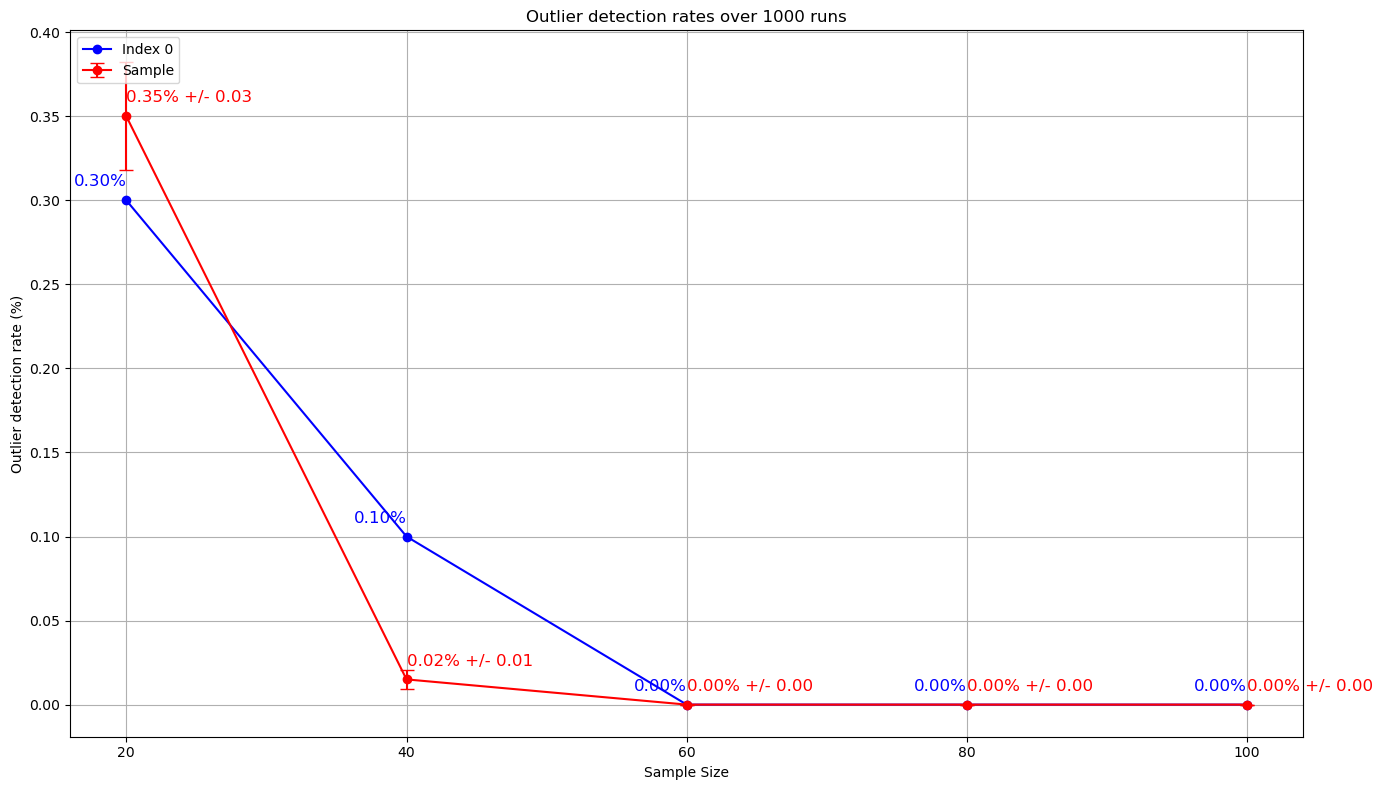

In [23]:
detection_rates = [(counts[size] / n_replicates) * 100 for size in subsample_sizes]

prc = {size: (id_dr[size] / n_replicates) * 100 for size in subsample_sizes}
means, errors, pop_size = list(), list(), list()
for n, flags in id_dr.items():
    percentages = (flags / n_replicates) * 100
    mean = np.mean(percentages)
    se = np.std(percentages, ddof=1) / np.sqrt(len(flags))
    means.append(mean)
    errors.append(se)
    pop_size.append(n)

plt.figure(figsize=(14, 8))
plt.plot(subsample_sizes, detection_rates, marker='o', linestyle='-', color='blue', label='Index 0')
for size, rate in zip(subsample_sizes, detection_rates):
    plt.annotate(f"{rate:.2f}%", (size, rate), textcoords="offset points", xytext=(0, 10), ha='right', fontsize=12, color='blue')

plt.errorbar(pop_size, means, yerr=errors, fmt='-o', capsize=5, color='red', label='Sample')
for (x, y, err) in zip(pop_size, means, errors):
    plt.annotate(f"{y:.2f}% +/- {err:.2f}", xy=(x, y), xytext=(0, 10), textcoords='offset points', ha='left', fontsize=12, color='red')

plt.xlabel('Sample Size')
plt.ylabel('Outlier detection rate (%)')
plt.title(f'Outlier detection rates over {n_replicates} runs')
plt.grid(True)
plt.xticks(subsample_sizes)
plt.legend(loc=2)
plt.tight_layout()
plt.show()


The outlier detection here refers to how often the injected noise produces an output that is statistically flagged as an outlier.

What this plot shows, is that across all subsample sizes, the outlier detection rate remains consistently at 0%. This means the added noise never creates anomalous or suspicious values, regardless of how large or small the sample is. The mechanism produces outputs that remain statistically plausible and naturally blend in with expected values.

However since the method is foundamentally based on randomness, and earlier we mentioned that smaller datasets are more sensetive, we can expect information breach in small datasets. 

### Comparison to local privacy

Local privacy is something that one is more accustomed to. We simply have to add noise on each subject. Of course in project in which the data are completely private this is not possible, which is why gobal privacy can be used. It is however beneficial to compare the approach and results here.

We start by creating the local_dp object which noise data rahter than user_output

In [24]:
def local_dp(clean_data):

    # now this is simply how far a subject is to the user_output
    sensitivity = np.abs(clean_data-user_output(clean_data))

    noise_values = np.zeros_like(clean_data)
    for i in range(len(clean_data)):
        while True:
            noise = np.random.normal(loc=0.0, scale=2*sensitivity[i], size=1)
            if abs(noise[0]) >= sensitivity[i]:
                noise_values[i] = noise[0]
                break
    noisy_data = clean_data + noise_values
    return noisy_data, sensitivity

In [25]:
def sim_local(n_replicates, subsample_sizes, OL=True):    
    id_dr = {size: np.zeros(size) for size in subsample_sizes} # stands for index detection rates
    counts = {size: 0 for size in subsample_sizes}
    reconstructed = {size: [] for size in subsample_sizes}
    true_means_ = {size: [] for size in subsample_sizes}
    sensitivities_ = {size: [] for size in subsample_sizes}
    error_ = {size: [] for size in subsample_sizes}
    
    for n in range(n_replicates):
        data = np.random.normal(loc=170, scale=10, size=100)
        for size in subsample_sizes:
            subsample = data[:size].copy()
            iqr_, lower_b, upper_b = iqr_bounds(subsample)
            
            if OL:
                outlier_val = lower_b - 100
                subsample[0] = outlier_val
            else: pass

            true_mean = np.mean(subsample)
            true_means_[size].append(true_mean)
            loo_data = np.array([np.delete(subsample, i) for i in range(len(subsample))])
            ######## PIPELINE ########
            private_data = []
            sens_outputs = []
            pr, se = local_dp(subsample)
            private_data.append(pr)
            sens_outputs.append(se)
            ######## RECONSTRUCTION ########
            coeff_mat = np.ones((size, size)) - np.eye(size)
            recons = np.linalg.solve(coeff_mat, (size - 1) * np.array(pr))
            iqr_, lower_b, upper_b = iqr_bounds(recons)

            recons_error = np.mean(abs(recons - subsample))
            error_[size].append(recons_error)
            sensitivities_[size].append(sens_outputs)
            reconstructed[size].append(recons)
            
            if outlier_(recons[0], lower_b, upper_b):
                counts[size] += 1
                
            for idx in range(size):
                if outlier_(recons[idx], lower_b, upper_b):
                    id_dr[size][idx] += 1
    return id_dr, counts, reconstructed, sensitivities_, error_


#id_dr_OL, counts_OL, reconstructed_OL, sensitivities_OL, error_OL = sim_local(n_replicates, subsample_sizes, OL=True)
id_dr, counts, reconstructed, sensitivities_, error_ = sim_local(n_replicates, subsample_sizes, OL=False)

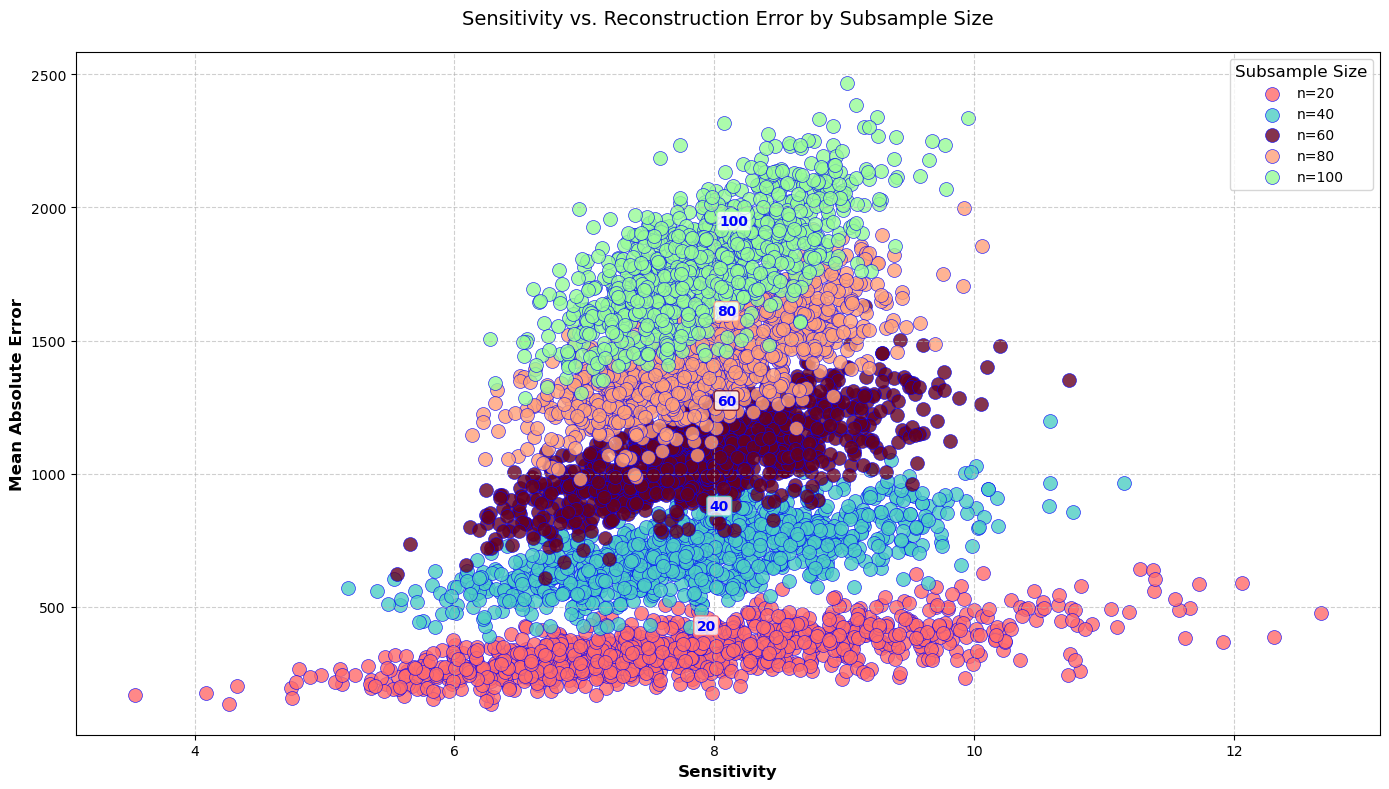

In [26]:
# https://matplotlib.org/stable/users/explain/colors/colors.html
color_map = {
    20: '#FF6B6B',  
    40: '#4ECDC4', 
    60: '#650021', 
    80: '#FFA07A',  
    100: '#98FB98' 
}

plt.figure(figsize=(14, 8))

for size in subsample_sizes:
    mean_sensitivity = np.mean(np.array(sensitivities_[size]).reshape(n_replicates, size), axis=1)
    plt.scatter(mean_sensitivity, 
                np.array(error_[size]),
                color=color_map[size],
                s=100,  
                alpha=0.8,
                edgecolors='b',  
                linewidth=0.5,
                label=f'n={size}')

    median_idx = np.argsort(mean_sensitivity)[len(mean_sensitivity)//2]
    plt.annotate(f'{size}',
                 xy=(mean_sensitivity[median_idx], np.array(error_[size])[median_idx]),
                 xytext=(10, 10),  
                 textcoords='offset points',
                 fontsize=10,
                 fontweight='bold',
                 color="b", 
                 bbox=dict(boxstyle='round,pad=0.2', 
                          fc='white', 
                          ec=color_map[size],  
                          alpha=0.8))

plt.xlabel('Sensitivity', fontsize=12, fontweight='bold')
plt.ylabel('Mean Absolute Error', fontsize=12, fontweight='bold')
plt.title('Sensitivity vs. Reconstruction Error by Subsample Size', 
          fontsize=14, pad=20)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Subsample Size', title_fontsize=12)

plt.tight_layout()
plt.show()

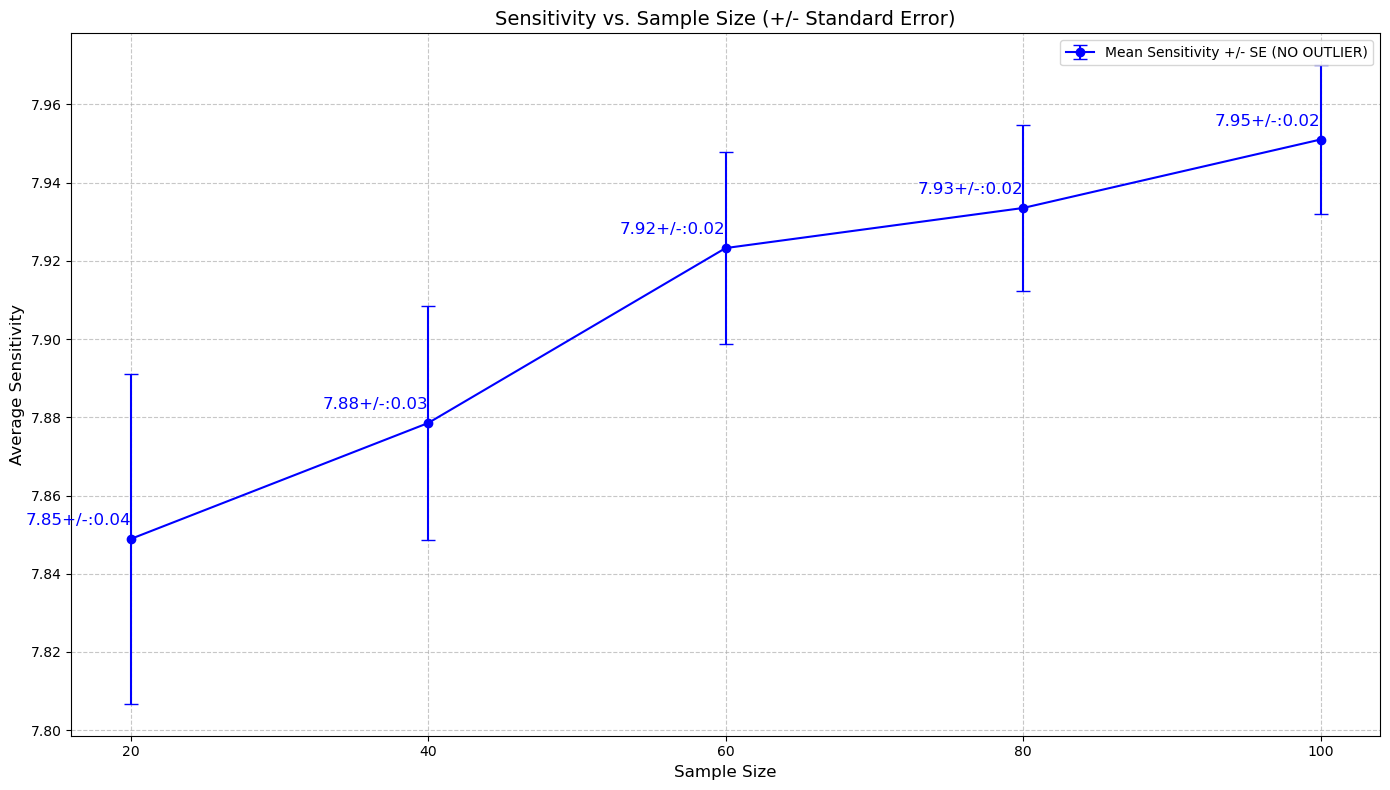

In [27]:
mean_sensitivities = list()
std_errors = list()

for size in subsample_sizes:
    all_sensitivities = np.array(sensitivities_[size]).flatten()
    mean_sens = np.mean(all_sensitivities)
    std_err = np.std(all_sensitivities) / np.sqrt(len(all_sensitivities))
    mean_sensitivities.append(mean_sens)
    std_errors.append(std_err)
    
plt.figure(figsize=(14, 8))

plt.errorbar(
    subsample_sizes, mean_sensitivities, yerr=std_errors,
    fmt='o-', capsize=5, color='blue',
    label='Mean Sensitivity +/- SE (NO OUTLIER)'
)


for size, sens, err in zip(subsample_sizes, mean_sensitivities, std_errors):
    plt.annotate(
        f"{sens:.2f}+/-:{err:.2f}", 
        (size, sens),
        textcoords="offset points", 
        xytext=(0, 10),
        ha='right', 
        fontsize=12,
        color='blue'
    )


plt.xlabel('Sample Size', fontsize=12)
plt.ylabel('Average Sensitivity', fontsize=12)
plt.title('Sensitivity vs. Sample Size (+/- Standard Error)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(subsample_sizes)
plt.legend(fontsize=10, loc='upper right')

plt.tight_layout()
plt.show()

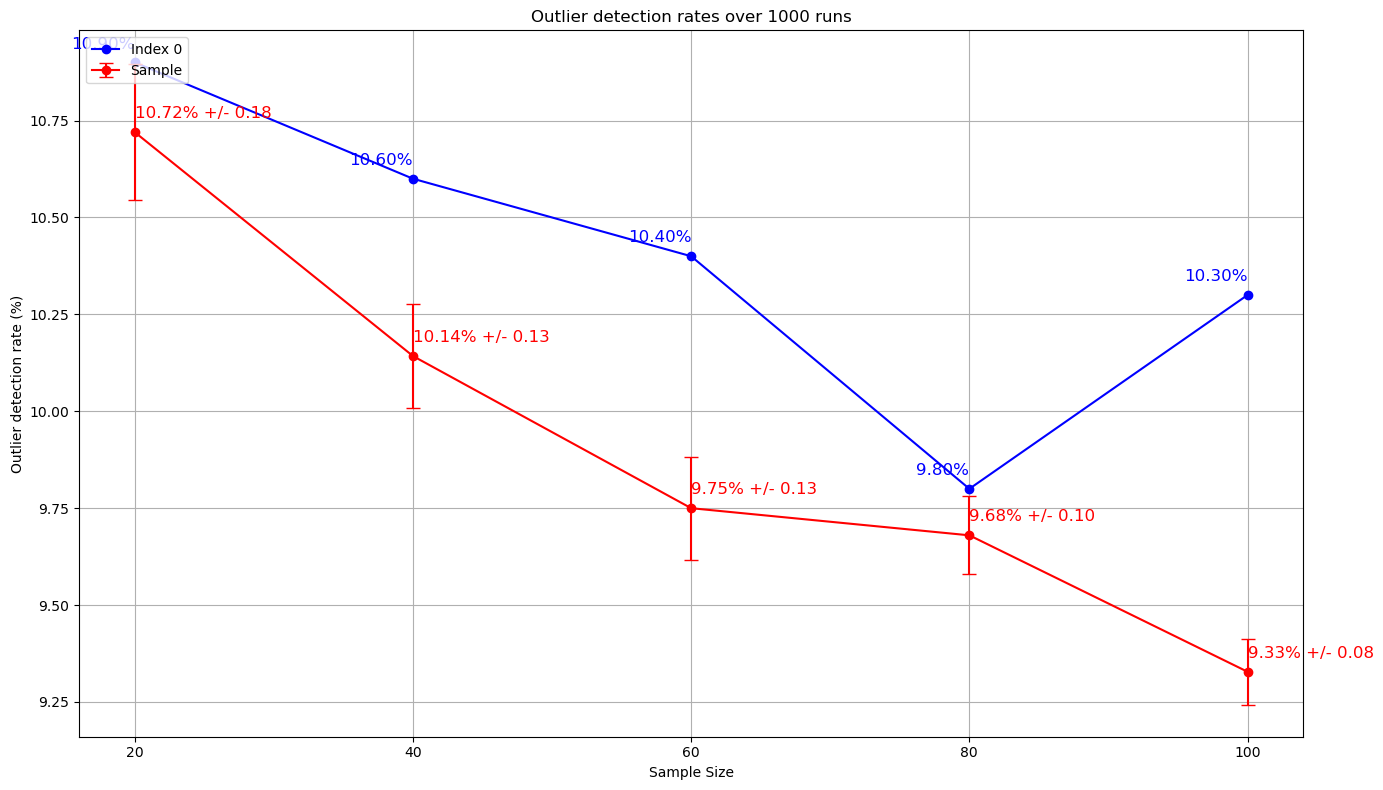

In [28]:
detection_rates = [(counts[size] / n_replicates) * 100 for size in subsample_sizes]

prc = {size: (id_dr[size] / n_replicates) * 100 for size in subsample_sizes}
means, errors, pop_size = list(), list(), list()
for n, flags in id_dr.items():
    percentages = (flags / n_replicates) * 100
    mean = np.mean(percentages)
    se = np.std(percentages, ddof=1) / np.sqrt(len(flags))
    means.append(mean)
    errors.append(se)
    pop_size.append(n)

plt.figure(figsize=(14, 8))
plt.plot(subsample_sizes, detection_rates, marker='o', linestyle='-', color='blue', label='Index 0')
for size, rate in zip(subsample_sizes, detection_rates):
    plt.annotate(f"{rate:.2f}%", (size, rate), textcoords="offset points", xytext=(0, 10), ha='right', fontsize=12, color='blue')

plt.errorbar(pop_size, means, yerr=errors, fmt='-o', capsize=5, color='red', label='Sample')
for (x, y, err) in zip(pop_size, means, errors):
    plt.annotate(f"{y:.2f}% +/- {err:.2f}", xy=(x, y), xytext=(0, 10), textcoords='offset points', ha='left', fontsize=12, color='red')

plt.xlabel('Sample Size')
plt.ylabel('Outlier detection rate (%)')
plt.title(f'Outlier detection rates over {n_replicates} runs')
plt.grid(True)
plt.xticks(subsample_sizes)
plt.legend(loc=2)
plt.tight_layout()
plt.show()
